# Notebook log
* UnderStanding Data
* Converting images into pixels
* IntroDuction to Dense Net
* Implementation of denseNet
* training with DenseNet
* Traning and Testing Visualisation
* Testing Our Model
* Advantages of Dense Net
* Submission of Competetion
* Exploring Others Notebook
* Refrences

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
df=pd.read_csv("../input/train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
print("Number of samples: ",len(df))
print("Number of Labels: ",np.unique(df.has_cactus))

Number of samples:  17500
Number of Labels:  [0 1]


# UnderStanding Data

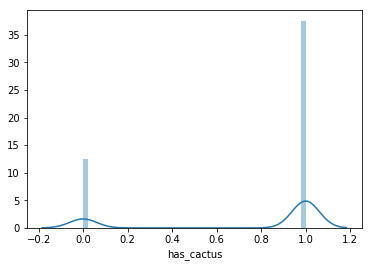

In [4]:
sns.distplot(df.has_cactus)

In [5]:
from PIL import Image 
from skimage.transform import resize
train=pd.read_csv("../input/train.csv")
train_images=[]
path="../input/train/train/"
for i in train.id:
    image=plt.imread(path+i)
    train_images.append(image)

In [6]:
train_images=np.asarray(train_images)
X=train_images
y=train.has_cactus
print("Labels: ",y.shape)
print("images: ",X.shape)

Labels:  (17500,)
images:  (17500, 32, 32, 3)


# image in dataset

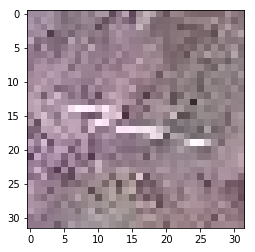

In [7]:
plt.imshow(X[2])

# IntroDuction to DenseNet (2018)

![](https://arthurdouillard.com/figures/densenet.png)
**Now we are going to use Dense net for classifying these Images**

DenseNet Architecture

The best way to illustrate any architecture is done with the help of code. So, I have implemented DenseNet architecture in Keras using MNIST data set.

*  **Dense Block: **
 A DenseNet consists of dense blocks. Each dense block consists of convolution layers. After a dense block a transition layer is added to proceed to next dense block
Every layer in a dense block is directly connected to all its subsequent layers. Consequently, each layer receives the feature-maps of all preceding layer.

* **Covolutional layers :**
 Each convolution layer is consist of three consecutive operations: batch normalization (BN) , followed by a rectified linear unit (ReLU) and a 3 × 3 convolution (Conv). Also dropout can be added which depends on your architecture requirement.An essential part of convolutional networks is down-sampling layers that change the size of feature-maps. To facilitate down-sampling in DenseNet architecture it divides the network into multiple densely connected dense blocks
 
* **Transition Block : **
 DenseNets can scale naturally to hundreds of layers, while exhibiting no optimization difficulties. Because of their compact internal representations and reduced feature redundancy, DenseNets may be good feature extractors for various computer vision tasks that build on convolutional features
 
 

# Implementation of denseNet

In [8]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam



def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)


Using TensorFlow backend.


# Setting Data set 

In [9]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)

print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (11725, 32, 32, 3)
y_train shape :  (11725, 2)
X_test shape :  (5775, 32, 32, 3)
y_test shape :  (5775,)


# Prediction with DenseNet

In [10]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 2
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()


# training
batch_size = 32
epochs = 10
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, shuffle=True,validation_data=(X_test, Cat_test_y))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 24)   0           activation_1[0][0]               
__________________________________________________________________________________________________
batch_norm

# Traning and Testing Visualisation

Generating plots...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import sys


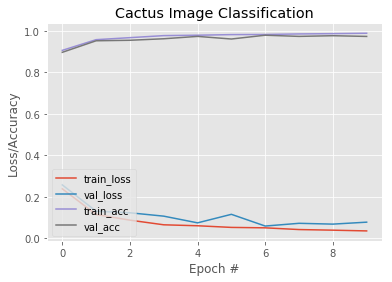

In [11]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
import sys
import matplotlib
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = epochs 
matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
matplotlib.pyplot.title("Cactus Image Classification")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

# Testing

**accuracy Score of each class**

In [12]:
from sklearn import metrics
label_pred = model.predict(X_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1419
           1       1.00      0.96      0.98      4356

    accuracy                           0.97      5775
   macro avg       0.95      0.98      0.96      5775
weighted avg       0.98      0.97      0.97      5775



Overall accuracy Score

In [13]:
from sklearn import metrics
label_pred = model.predict(X_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.accuracy_score(Y_test, pred))

0.972987012987013


# Advantages of DenseNet

* **Strong Gradient Flow**

Implicit “Deep Supervision”
The error signal can be easily propagated to earlier layers more directly. This is a kind of implicit deep supervision as earlier layers can get direct supervision from the final classification layer.

* **Parameter & Computational Efficiency**

Number of Parameters for ResNet and DenseNet
For each layer, number of parameters in ResNet is directly proportional to C×C while Number of parameters in DenseNet is directly proportional to l×k×k.

Since k<<C, DenseNet has much smaller size than ResNet.

* **More Diversified Features**

More Diversified Features in DenseNet
Since each layer in DenseNet receive all preceding layers as input, more diversified features and tends to have richer patterns.

* **Maintains Low Complexity Features**

Standard ConvNet
In Standard ConvNet, classifier uses most complex features.


DenseNet
In DenseNet, classifier uses features of all complexity levels. It tends to give more smooth decision boundaries. It also explains why DenseNet performs well when training data is insufficient.

# Submission to the competition

In [14]:
#training all data on this model
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
batch_size = 32
epochs = 20
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])
y= np_utils.to_categorical(y)
history=model.fit(X,y, epochs=epochs, batch_size=batch_size, shuffle=True,verbose=0)

In [15]:
from PIL import Image 
from skimage.transform import resize
sample=pd.read_csv("../input/sample_submission.csv")
test_images=[]
path="../input/test/test/"
for i in sample.id:
    image=plt.imread(path+i)
    test_images.append(image)

In [16]:
# prediction
test_images=np.asarray(test_images)
test_images=test_images.reshape(test_images.shape[0],32,32,3)
pred1=model.predict(test_images)
pred = []
for i in range(len(test_images)):
    pred.append(np.argmax(pred1[i]))


results = pd.DataFrame({"id" : sample.id, "has_cactus": pred})
results.to_csv("submission.csv", index = False)

# Exploring Others Notebook
**Notebook got Highest Accuracy with densenet (pretrained)**

https://www.kaggle.com/kenseitrg/simple-fastai-exercise

# Refrences

* https://towardsdatascience.com/densenet-2810936aeebb
* https://theailearner.com/2018/12/09/densely-connected-convolutional-networks-densenet/
* https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803